In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from gcpUtils.auth import getCredentials
from gcpUtils.bigQuery import pandasToBq, tableToPandas
from gcpUtils.google_storage_manager import *

cred = getCredentials("planejamento-animale-292719-296d49ccdea6.json")

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

In [157]:
query = """
WITH rupturas AS (
    SELECT
        FILIAL,
        SKU,
        DATA,
        CONT_RUPTURA,
        LEADTIME,
        CASE 
            WHEN CONT_RUPTURA = 1
                AND LAG(CONT_RUPTURA, 1, 0) OVER (
                    PARTITION BY FILIAL, SKU ORDER BY DATA
                ) = 0
            THEN 1 ELSE 0
        END AS inicio_ruptura
    FROM `planejamento-animale-292719.checklists_rollout.ANIMALE_checklist`
    WHERE DATA > '2024-09-01' 
      AND DATA < '2025-09-01'
      AND FILIAL LIKE '%CM%' 
),
grupos AS (
    SELECT
        FILIAL,
        SKU,
        DATA,
        CONT_RUPTURA,
        LEADTIME,
        SUM(inicio_ruptura) OVER (
            PARTITION BY FILIAL, SKU ORDER BY DATA ROWS UNBOUNDED PRECEDING
        ) AS RUPTURA_ID
    FROM rupturas
    WHERE CONT_RUPTURA = 1
),
resumo AS (
    SELECT
        FILIAL,
        SKU,
        RUPTURA_ID,
        MIN(CAST(DATA AS DATE)) AS inicio_ruptura,
        MAX(CAST(DATA AS DATE)) AS fim_ruptura,
        DATE_DIFF(
        MAX(CAST(DATA AS DATE)), MIN(CAST(DATA AS DATE)), DAY
        ) + 1 AS DIAS_RUPTURA,
        MAX(LEADTIME) AS LEADTIME,
    FROM grupos
    GROUP BY FILIAL, SKU, RUPTURA_ID
)
SELECT *
FROM resumo
ORDER BY FILIAL, SKU, RUPTURA_ID;
"""

dados = tableToPandas(query, 'planejamento-animale-292719', cred)
dados.columns = dados.columns.str.upper()

In [158]:
# calculando IET e classificação
epsilon = 1e-9
dados['IET'] = (dados['LEADTIME'] - dados['DIAS_RUPTURA']) / \
               (dados['LEADTIME'] + dados['DIAS_RUPTURA'] + epsilon)

conditions = [
    dados['IET'] < -0.25,  # Ruim: IET menor que -0.25
    dados['IET'] > 0.25,   # Bom: IET maior que 0.25
]
choices = ['Ruim', 'Bom']
dados['CLASSE'] = np.select(conditions, choices, default='Razoável')

(dados.head(10))

,FILIAL,SKU,RUPTURA_ID,INICIO_RUPTURA,FIM_RUPTURA,DIAS_RUPTURA,LEADTIME,IET,CLASSE
0,ANIMALE ALPHAVILLE CM,03.01.1448-0005-TAM_2,1,2024-12-30,2025-01-28,30,13.320000,-0.385042,Ruim
1,ANIMALE ALPHAVILLE CM,03.01.1448-0005-TAM_3,1,2024-12-30,2025-01-28,30,13.320000,-0.385042,Ruim
2,ANIMALE ALPHAVILLE CM,03.01.1469-0005-TAM_2,1,2024-12-30,2024-12-30,1,3.000000,0.5,Bom
3,ANIMALE ALPHAVILLE CM,03.01.1469-0005-TAM_2,2,2025-05-11,2025-06-17,38,10.565000,-0.564913,Ruim
4,ANIMALE ALPHAVILLE CM,03.01.1469-0005-TAM_3,1,2024-12-30,2025-01-28,30,13.320000,-0.385042,Ruim
5,ANIMALE ALPHAVILLE CM,03.01.1474-0005-TAM_2,1,2024-12-30,2024-12-30,1,3.000000,0.5,Bom
6,ANIMALE ALPHAVILLE CM,03.01.1474-0005-TAM_2,2,2025-04-23,2025-06-17,56,11.491666,-0.659464,Ruim
7,ANIMALE ALPHAVILLE CM,03.01.1474-0005-TAM_3,1,2024-12-30,2025-01-28,30,13.320000,-0.385042,Ruim
8,ANIMALE ALPHAVILLE CM,03.01.1474-0005-TAM_4,1,2024-12-30,2025-01-28,30,13.320000,-0.385042,Ruim
9,ANIMALE ALPHAVILLE CM,03.01.1474-0005-TAM_5,1,2024-12-30,2025-01-28,30,13.320000,-0.385042,Ruim


In [159]:
# Contagem de lojas por classe
contagem_classe = dados['CLASSE'].value_counts()

lojas_media_ruptura = dados.groupby('FILIAL').agg(
    DIAS_RUPTURA_MEDIA=('DIAS_RUPTURA', 'mean')
).reset_index()

lojas_media_ruptura

,FILIAL,DIAS_RUPTURA_MEDIA
0,ANIMALE ALPHAVILLE CM,24.22351
1,ANIMALE ARACAJU CM,18.671373
2,ANIMALE BALNEARIO SHOP CM,20.481594
3,ANIMALE BARIGUI CM,18.795844
4,ANIMALE BARRA SALVADOR CM,18.002042
...,...,...
60,ANIMALE VILA NOVA CM,18.883502
61,ANIMALE VILA VELHA CM,18.994278
62,ANIMALE VILLA LOBOS CM,21.180812
63,ANIMALE VILLAGE MALL CM,20.816552


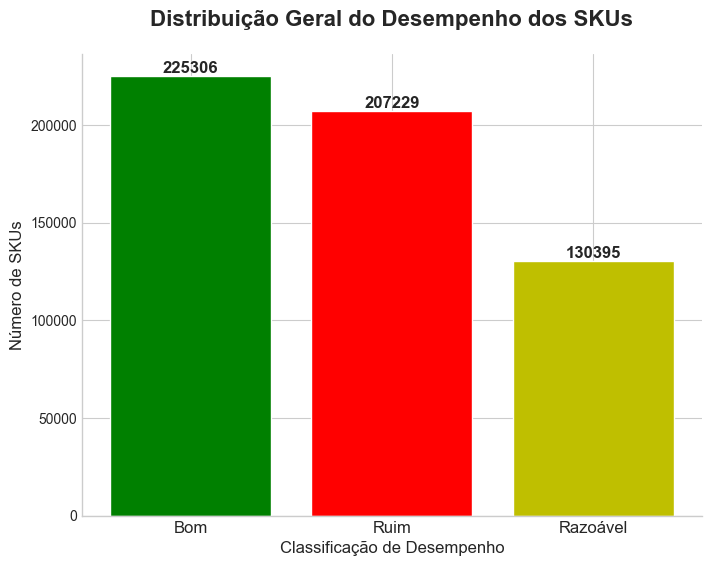

In [160]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(
    contagem_classe.index, 
    contagem_classe.values, 
    color=('g','r','y')
)

ax.bar_label(bars, fontsize=12, fontweight='bold')

ax.set_title('Distribuição Geral do Desempenho dos SKUs', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Número de SKUs', fontsize=12)
ax.set_xlabel('Classificação de Desempenho', fontsize=12)
ax.tick_params(axis='x', labelsize=12)

ax.spines[['top', 'right']].set_visible(False)
plt.show()

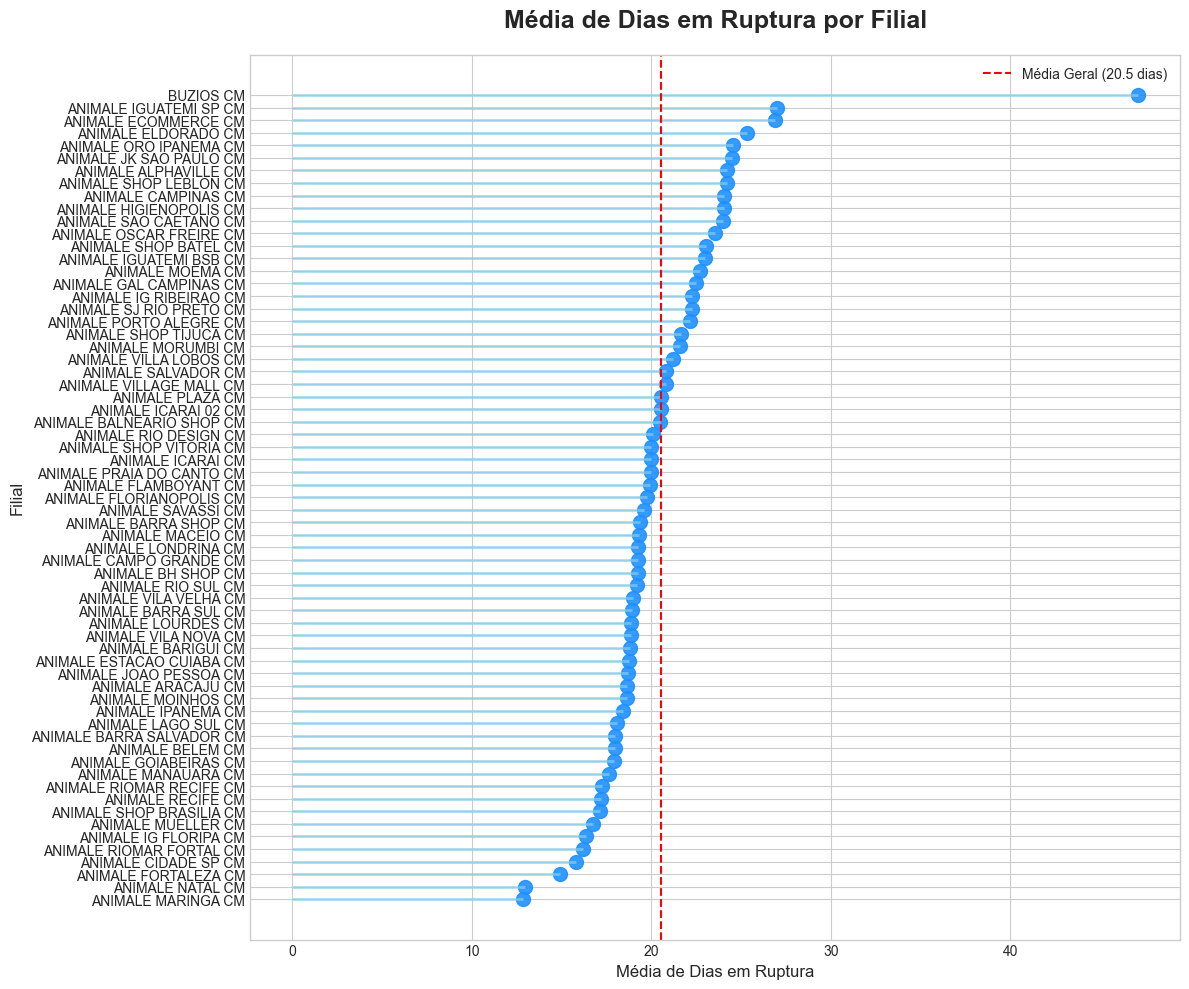

In [161]:
# Seus dados já estão prontos em 'lojas_media_ruptura'

# Ordenando os dados para a visualização
lojas_media_ruptura_sorted = lojas_media_ruptura.sort_values('DIAS_RUPTURA_MEDIA', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))

# Criando as "hastes" e os "pontos"
ax.hlines(y=lojas_media_ruptura_sorted['FILIAL'], xmin=0, xmax=lojas_media_ruptura_sorted['DIAS_RUPTURA_MEDIA'], color='skyblue', alpha=0.7, linewidth=2)
ax.scatter(x=lojas_media_ruptura_sorted['DIAS_RUPTURA_MEDIA'], y=lojas_media_ruptura_sorted['FILIAL'], s=100, color='dodgerblue', alpha=0.9)

# Linha da média geral para contexto
media_geral = lojas_media_ruptura_sorted['DIAS_RUPTURA_MEDIA'].mean()
ax.axvline(x=media_geral, color='red', linestyle='--', linewidth=1.5, label=f'Média Geral ({media_geral:.1f} dias)')
ax.legend()

# Títulos e labels
ax.set_title('Média de Dias em Ruptura por Filial', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Média de Dias em Ruptura', fontsize=12)
ax.set_ylabel('Filial', fontsize=12)

plt.tight_layout()
plt.show()

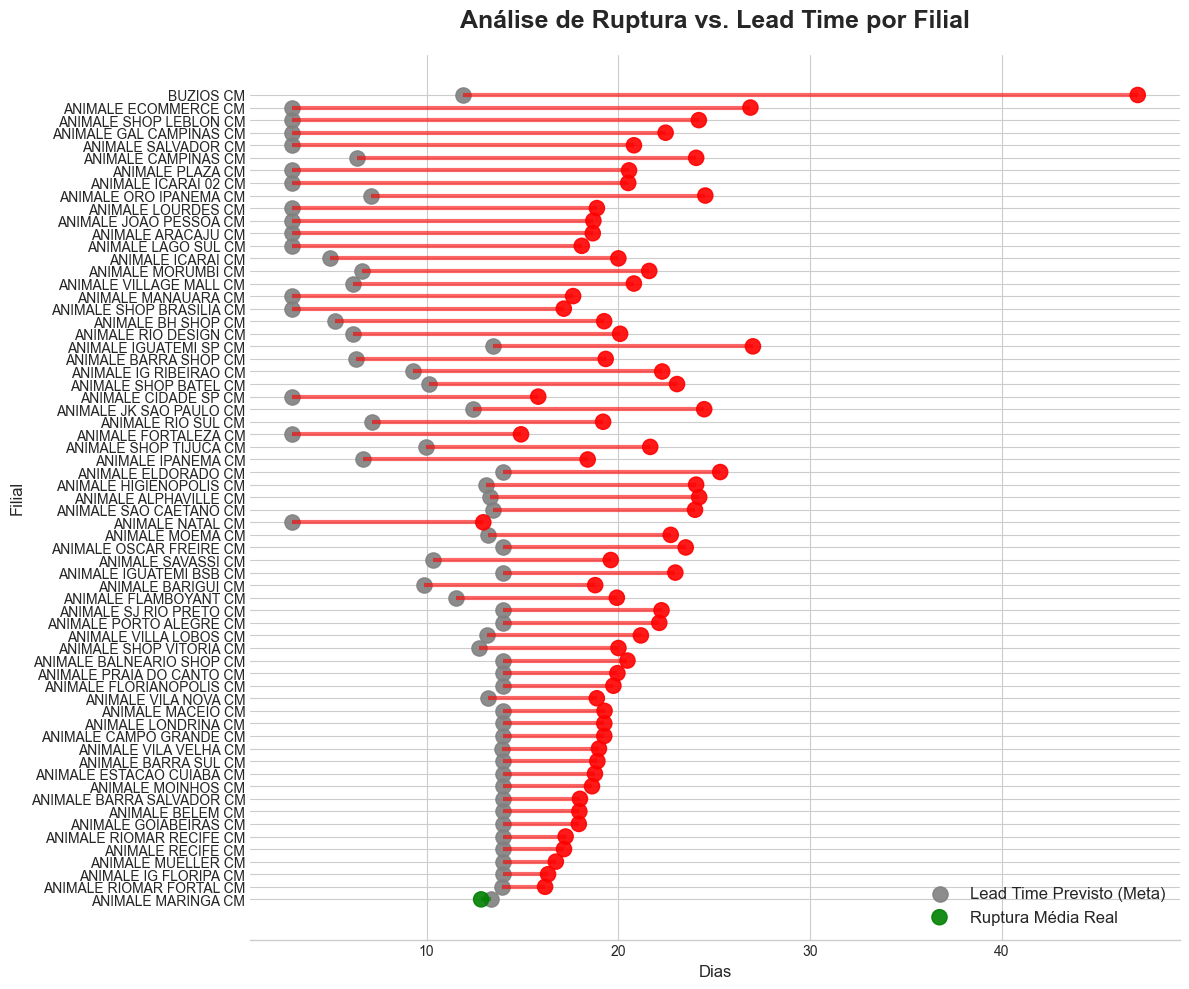

In [162]:
# Definindo as cores para cada situação
cores = {'Acima do Previsto': 'red', 'Dentro do Previsto': 'green'}
dados_comparativos['COR'] = dados_comparativos['SITUACAO'].map(cores)

# Criando a figura
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 10))

# Desenhando as linhas (a "haste" do haltere)
ax.hlines(
    y=dados_comparativos['FILIAL'], 
    xmin=dados_comparativos['LEADTIME_PREVISTO'], 
    xmax=dados_comparativos['DIAS_RUPTURA_MEDIA'], 
    color=dados_comparativos['COR'], # A cor da linha indica a situação
    alpha=0.6,
    linewidth=3
)

# Desenhando os pontos para o Lead Time (a meta)
ax.scatter(
    x=dados_comparativos['LEADTIME_PREVISTO'], 
    y=dados_comparativos['FILIAL'], 
    s=120, 
    color='gray', 
    alpha=0.9,
    label='Lead Time Previsto (Meta)'
)

# Desenhando os pontos para a Ruptura Média (o real)
ax.scatter(
    x=dados_comparativos['DIAS_RUPTURA_MEDIA'], 
    y=dados_comparativos['FILIAL'], 
    s=120, 
    color=dados_comparativos['COR'], # A cor do ponto também indica a situação
    alpha=0.9,
    label='Ruptura Média Real'
)

ax.set_title('Análise de Ruptura vs. Lead Time por Filial', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Dias', fontsize=12)
ax.set_ylabel('Filial', fontsize=12)
ax.legend(fontsize=12, loc='best')

ax.tick_params(axis='y', length=0)
ax.spines[['top', 'right', 'left']].set_visible(False)

plt.tight_layout()
plt.show()